In [244]:
# Import various dependencies, including the relevant modules from the Perch
# repository. Note that "chirp" is the old name that the Perch team used, so any
# chirp modules imported here were installed as part of the Perch repository in
# one of the previous cells.

import collections
from etils import epath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import shutil
import tensorflow as tf
from tqdm import tqdm
import os
import json

from chirp import audio_utils
from chirp.inference import embed_lib
from chirp.inference import tf_examples
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib
from utils_agile_model import choose_embedding_model

In [247]:
# Check GPU is used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load paths and model selection from config dictionary 

In [275]:
path_to_config = './config_dict.json'
paths_dictionary = json.load(open(path_to_config, 'r'))

# Define paths frpm the config dictionary
sample_data_folder = os.path.join(paths_dictionary['working_repo'], paths_dictionary['sample_data_folder'])
output_directory = os.path.join(paths_dictionary['working_repo'], paths_dictionary['output_directory'])
dataset_folder = paths_dictionary['deployment_folder']
embedding_models_folder = os.path.join(paths_dictionary['working_repo'], paths_dictionary['embedding_models_folder'])
model_name = paths_dictionary['model_name']
experiment_name = paths_dictionary['experiment_name']
sound_name = paths_dictionary['sound_name']

unlabeled_audio_pattern = os.path.join(sample_data_folder, dataset_folder, 'raw_audio/*.[wW][aA][vV]')

print("Path to dataset: ", sample_data_folder)
print("Output data folder: ", output_directory)
print(f"Working on deployment: {dataset_folder} \nUsing {model_name}")
print("Experiment name: ", experiment_name)

Path to dataset:  ./eval_texel Data/
Output data folder:  ./eval_texel Outputs/
Working on deployment: september 2024/ 
Using birdnet
Experiment name:  texel_birdnet_hockey_11_20250307


In [252]:
# Choose embeddings model
embed_fn, config = choose_embedding_model(model_name, embedding_models_folder)

# For readability later in the code
sample_rate = config.embed_fn_config.model_config.sample_rate
hop_size_s = config.embed_fn_config.model_config.hop_size_s
window_size_s = config.embed_fn_config.model_config.window_size_s

print(f"Ready to use Agile Modeling with '{model_name}' model")
print(f"Sampling rate:{sample_rate}Hz, Window size:{window_size_s}sec, Hop size:{hop_size_s}sec")

# Specify a glob pattern matching any number of wave files.
# Use [wW][aA][vV] to match .wav or .WAV files
unlabeled_audio_pattern = os.path.join(sample_data_folder, dataset_folder, 'raw_audio/*.[wW][aA][vV]')



Loading birdnet...
Test-run of model...

Setup complete!
Ready to use Agile Modeling with 'birdnet' model
Sampling rate:48000Hz, Window size:3.0sec, Hop size:3.0sec


## Retrieve embeddings of training set

In [253]:
# Folder with the embeddings
embedding_output_dir = os.path.join(output_directory, dataset_folder, model_name, 'raw_embeddings')
config.output_dir = embedding_output_dir
config.source_file_patterns = [unlabeled_audio_pattern]

# # Create output directory and write the configuration.
# output_dir = epath.Path(config.output_dir)
# output_dir.mkdir(exist_ok=True, parents=True)

# Check that embeddings exist and are in the output directory
if os.path.isfile(os.path.join(config.output_dir,'config.json')):
    print("Config file found. Loading embeddings metadata.")
    # Get parameters from json config files
    # Open and read the JSON file
    with open(os.path.join(config.output_dir,'config.json'), 'r') as file:
        embedding_config = json.load(file)
    config.shard_len_s = embedding_config['shard_len_s']
    config.num_shards_per_file = embedding_config['num_shards_per_file']
    config.tf_record_shards = embedding_config['tf_record_shards']

    if len(os.listdir(embedding_output_dir)) == (config.tf_record_shards + 1):
        print("Embeddings found.")
    else:
        print("Number of embeddings files does not match config. the embeddings creation was not cleanly done.")
        
else:
    print("Config and embedding files not found. Go to create_embeddings.ipynb or verify paths")

Config file found. Loading embeddings metadata.
Embeddings found.


### Write the configuration to JSON to ensure consistency with later stages of the pipeline

In [254]:
# Create SourceInfos configuration, used in sharded computation when computing embeddings. These source_infos contain metadata about how we're going to
# partition the search corpus. In particular, the audios are splitted into hundreds of 5s chunks. The source_infos help us keep track of
# which chunk came from which raw audio file.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    config.num_shards_per_file,
    config.shard_len_s)
print(f'Constructed {len(source_infos)} source infos.')     #Should match the number of wav files in raw audio folder

Constructed 916 source infos.


## Retrieve Ground Truth files


In [255]:
# Similar path to the one used in create_test_set_data.ipynb
test_set_path = os.path.join(output_directory, dataset_folder, model_name, 'test_set/')

# Load the test_set with pickle
pickle_filename = 'test_set.pkl'

# Check that the test_set exists
try:
    df_test_set = pd.read_pickle(test_set_path + pickle_filename)
    print("Test set found.")
except:
    print("Test set not found. Go to create_test_set_data.ipynb or verify paths")

print("Number of samples per class in the test set:\n", df_test_set['Label'].value_counts())

# Extract embeddings and labels for evaluation
df_test_set['label_int'] = df_test_set['Label'].map({'NEG': 0, sound_name: 1})
testset_embeddings = np.vstack(df_test_set['Embedding'].to_numpy())
testset_labels = df_test_set['label_int'].to_numpy()

Test set found.
Number of samples per class in the test set:
 Label
NEG    11944
A         54
Name: count, dtype: int64


<a name=similarity-search></a>
## Audio Similarity Search 🔎


### Target sounds

Selection of target sounds provided in your dataset folder

Number of different target sounds:  2
Target sound label:  fishB


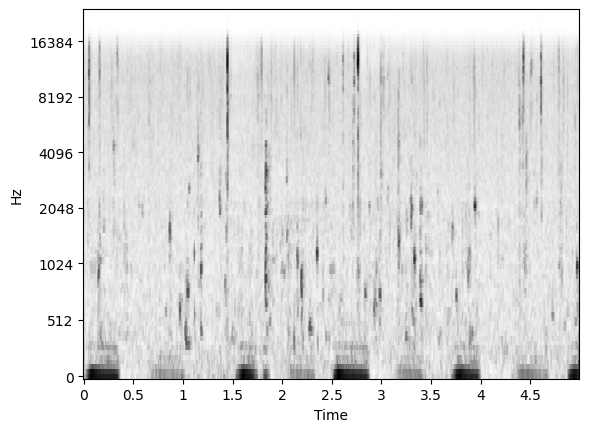

Target sound label:  fishA


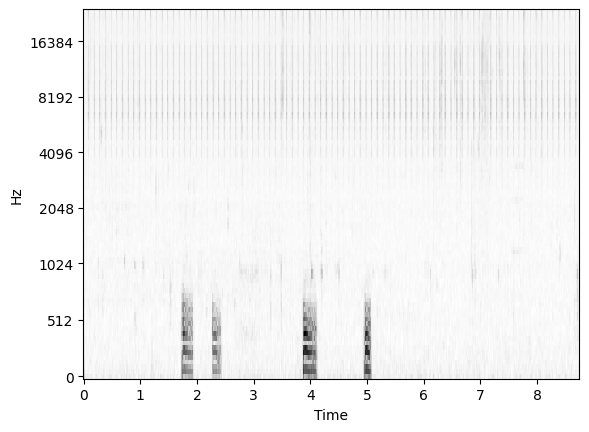

In [256]:
#@title { vertical-output: true }
# Path to ref target sound folders
target_sounds = os.path.join(sample_data_folder, dataset_folder, 'ref_sound')
target_sounds_folders = os.listdir(target_sounds)

# For each target sound folder, find the first audio file as an example
example_target_sounds = []
for folder in target_sounds_folders:
  wav_files = [file for file in os.listdir(os.path.join(target_sounds, folder)) if file.lower().endswith('.wav')]
  example_sound_path = os.path.join(target_sounds, folder + '/' + wav_files[0])
  example_target_sounds.append(example_sound_path)

# Now view each example target sound
print('Number of different target sounds: ', len(example_target_sounds))
for audio_path in example_target_sounds:
  print('Target sound label: ', audio_path.split('/')[-2])
  audio = audio_utils.load_audio(audio_path, sample_rate)
  display.plot_audio_melspec(audio, sample_rate)

In [257]:
# Ensure the path exists and list directories
if os.path.exists(target_sounds):
    sound_folders = [f for f in os.listdir(target_sounds) if os.path.isdir(os.path.join(target_sounds, f))]
else:
    print("Path does not exist:", target_sounds)
    sound_folders = []

# Choose the target sound
target_sound = sound_name
target_classes = [target_sound, 'Unknown']


### Prepare the query vector

We're now ready to create the 'query', which uses our selected target sound.  In general, this query is the audio that you're looking for in your search corpus.

Number of indexed audio files in target sound directory: 1
Viewing example: 1
Selected audio window:


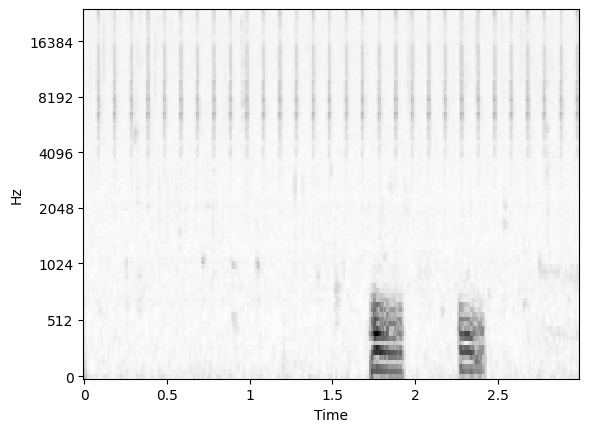

In [258]:
# Select one of the target audio files. Default with 0.
# Choose which ref sound to use for the similarity search.
file_index = 0  #@param

# Build the folder path
target_audio_folder = os.path.join(sample_data_folder, dataset_folder, 'ref_sound', target_sound)

# Retrieve all .wav files
wav_files = [file for file in os.listdir(target_audio_folder) if file.lower().endswith('.wav')]

# Print the total number of audio files
print(f"Number of indexed audio files in target sound directory: {len(wav_files)}")

audio_path = os.path.join(target_audio_folder, wav_files[file_index])
print(f"Viewing example: {file_index + 1}")

# Assuming the rest of the code executes only if a valid path is selected
if audio_path:
    audio = audio_utils.load_audio(audio_path, sample_rate)

    # If you're audio clip is longer than 5s, adjust start_s to pick your prefered start time.
    start_s = 0  

    # Display the selected window.
    print('Selected audio window:')
    st = int(start_s * sample_rate)
    end = int(st + window_size_s * sample_rate)
    if end > audio.shape[0]:
        end = audio.shape[0]
        st = max([0, int(end - window_size_s * sample_rate)])
    audio_window = audio[st:end]
    display.plot_audio_melspec(audio_window, sample_rate)

    query_audio = audio_window
    sep_outputs = None


#### Copy target samples to our labeled data directoy
It is possible to provide several target sounds, which will provide already labelled example for the model. Here, we will move the provided reference sounds to the `labeled_data_path`, which is the folder where the additional samples we find during the search phase later will be added.

The search phase may well find some of the same samples. The code will make sure not to save duplicate copies.

In [259]:
# The path to an empty directory where the generated labeled samples will be
# placed. Each labeled sample will be placed into a subdirectory corresponding
# to the target class that we select for that sample.
target_audio_outputs = os.path.join(output_directory, dataset_folder, model_name,'labeled_outputs', experiment_name, target_sound)
os.makedirs(target_audio_outputs, exist_ok=True)

# Copy all .wav and .WAV files from target_audio_folder to labeled_data_path
for file in os.listdir(target_audio_folder):
    if file.lower().endswith('.wav'):
        source_path = os.path.join(target_audio_folder, file)
        destination_path = os.path.join(target_audio_outputs, file)
        shutil.copy2(source_path, destination_path)

# Embed the query audio
embedded_query = embed_fn.embedding_model.embed(query_audio).embeddings[ :, 0, :]

### Create a TensorFlow Dataset (TFDS) wrapper over the embeddings

In [260]:
# Use the embedded dataset that we created above...
bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embedding_output_dir,
      annotated_path=target_audio_outputs)

project_state = bootstrap.BootstrapState(
    bootstrap_config, embedding_model=embed_fn.embedding_model)

embeddings_ds = project_state.create_embeddings_dataset()

### <a name=top-k-search></a>Run top-k search using a comparison metric
We use euclidean

In [261]:
# Number of search results to capture. top_k = 25 is often a good start
top_k = 5 # @param {type:"number"}

# The Perch codebase supports:
#  'euclidean', which is the standard euclidean distance
#  'cosine', which is the cosine similarity,
#  'mip', which is Maximum Inner Product
metric = 'euclidean'  #@param['euclidean', 'mip', 'cosine']

# Target distance for search results. This lets us try to hone in on a
# 'classifier boundary' instead of just looking at the closest matches.
# Set to 'None' for raw 'best results' search.
target_score = None #@param
results, all_scores = search.search_embeddings_parallel(
    embeddings_ds, embedded_query,
    hop_size_s=hop_size_s,
    top_k=top_k, target_score=target_score, score_fn=metric,
    random_sample=False)

916it [00:00, 1553.48it/s]


### Choose a target score by plotting a histogram of all distances in the search corpus


In [ ]:
#@title { vertical-output: true }
# Plot histogram of distances.
ys, _, _ = plt.hist(all_scores, bins=128, density=True)
hit_scores = [r.score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)

plt.xlabel(metric)
plt.ylabel('density')
if target_score is not None:
  plt.plot([target_score, target_score], [0.0, np.max(ys)], 'r:')
  # Compute the proportion of scores < target_score.
  hit_percentage = (all_scores < target_score).mean()
  print(f'score < target_score percentage : {hit_percentage:5.3f}')
min_score = np.min(all_scores)
plt.plot([min_score, min_score], [0.0, np.max(ys)], 'g:')

plt.show()

### User-in-the-loop data labeling

In [ ]:
display.display_search_results(
    project_state=project_state,
    results=results,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    checkbox_labels=target_classes,
    max_workers=5)
  
# Let this cell finish executing before labeling the samples

### Write the user-annotated search results to file

This cell saves the annotations you generated in the previous step to your output folder.  It writes data to the `labeled_data_path` location that was specified above.

In [262]:
def write_labeled_data(search_results, labeled_data_path: str, sample_rate: int):
  """Write labeled results to the labeled data collection."""
  labeled_data_path = epath.Path(labeled_data_path)
  counts = collections.defaultdict(int)
  duplicates = collections.defaultdict(int)
  for r in search_results:
    labels = [ch.description for ch in r.label_widgets if ch.value]
    if not labels:
      continue
    extension = epath.Path(r.filename).suffix
    filename = epath.Path(r.filename).name[: -len(extension)]
    output_filename = f'{filename}___{r.timestamp_offset}{extension}'
    for label in labels:
      output_path = labeled_data_path / label
      output_path.mkdir(parents=True, exist_ok=True)
      output_filepath = epath.Path(output_path / output_filename)
      if output_filepath.exists():
        duplicates[f'{label}'] += 1
        continue
      else:
        counts[label] += 1
      with output_filepath.open('wb') as f:
        wavfile.write(f, sample_rate, np.float32(r.audio))
  for label, count in counts.items():
    print(f'Wrote {count} examples for label {label}')
  for label, count in duplicates.items():
    print(f'Not saving {count} duplicates for label {label}')

labeled_data_path = os.path.join(output_directory, dataset_folder, model_name, 'labeled_outputs',  experiment_name)
write_labeled_data(results, labeled_data_path, sample_rate)

<a name=active-learning></a>
## Train a Linear Classifier with active learning 🔃  🤖 🧠

#### Active learning step 2
Here, we should have the number of samples we agreed on in the folder, from the previous step

In [263]:
# @title Load and embed the search-annotated dataset { vertical-output: true }

# Load the training data that is located in the `labeled_data_path` directory.
# In that directory there will be folders corresponding to our target labels

merged = data_lib.MergedDataset.from_folder_of_folders(
    base_dir=labeled_data_path,
    embedding_model=project_state.embedding_model,
    time_pooling='mean',
    load_audio=False,
    target_sample_rate=-2,
    audio_file_pattern='*',
    embedding_config_hash=bootstrap_config.embedding_config_hash(),
)

# Label distribution
value_counts = np.unique(merged.data['label_str'], return_counts=True)
print("\nNumber of samples per class: ", dict(zip(value_counts[0], value_counts[1])))
print("Please check that it corresponds to what you want for this iteration")

Embedding from Folder of Folders...
Checking for existing embeddings from Folder of Folders...
Found 0 existing embeddings.
Checking for new sources to embed from Folder of Folders...


1it [00:00,  3.86it/s]


...embedded dataset in  0.26s...
    found 1 classes.
    class fishA / 0 : 1

Number of samples per class:  {'fishA': 1}
Please check that it corresponds to what you want for this iteration


### Train a simple linear model using the labeled embeddings

We don't consider the following as parameter in our study so they are kept by default.
We use the following hyperparameters which should serve as reasonably performing defaults to train this linear model (classifier):

- `batch_size`: 12
- `num_epochs`: 128
- `num_hiddens`: -1 (to match the dimensions of the embeddings)
- `learning_rate`: 0.001

Additionally, we compute the following metrics to measure the "goodness" of the trained model:
- `auc_roc`: AUC ROC, or area under the receiving curve
- `macro f1`: f1 score, calculated from precision and recall
- `auc_pr`: AUC-PR (?)


### Overwrite train_embedding_model to access logits and ground truth labels
The AUC_ROC can return an error if there is not enough samples in the validation set.

In [ ]:
from utils_agile_model import train_from_index
# Classifier training hyperparams.
# These should be good defaults.
batch_size = 12
num_epochs = 128
num_hiddens = -1
learning_rate = 1e-3

### 5-fold Validation training
1. Define the metrics to calculate
2. Use 5-fold validation to train 5 models (split 80/20)
3. Evaluate the metrics for the validation set
4. Run predictions on the test set
5. Evaluate the metrics for the test set


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, auc

def metrics_from_logits_and_labels(logits, labels, metrics=collections.defaultdict(list), verbose=False):
    predictions = tf.argmax(logits, axis=1).numpy()
    prec_score = precision_score(labels, predictions, average='macro')
    rec_score = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    auc_roc = roc_auc_score(labels, logits[:,1]) 
    precision, recall, _thresholds = precision_recall_curve(labels, logits[:,1])
    auc_precision_recall = auc(recall, precision)
    
    if verbose:
        print(f'Precision: {prec_score}')
        print(f'Recall: {rec_score}')
        print(f'F1: {f1}')
        print(f'AUC-ROC: {auc_roc}')
        print(f'AUC-PR: {auc_precision_recall}')

    metrics['precision'].append(prec_score)
    metrics['recall'].append(rec_score)
    metrics['f1'].append(f1)
    metrics['auc_roc'].append(auc_roc)
    metrics['auc_pr'].append(auc_precision_recall)
        
    return metrics

In [ ]:
value_counts[1].sum()

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Duplicate of cell bellow to compute different metrics
validation_metrics_list = collections.defaultdict(list)
testset_metrics_list = collections.defaultdict(list)

# Create the 5-fold validation object
seed = 0
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Get the number of positive samples for saving paths
count_training_samples = value_counts[1].sum()

# Iterate over the folds
for i, (train_index, test_index) in tqdm(enumerate(kf.split(merged.data['embeddings'], merged.data['label'])), total=kf.n_splits):

    model = classify.get_linear_model(merged.embedding_dim, merged.num_classes)
    
    run_metrics = train_from_index(
      model, merged, num_epochs, train_index, test_index, batch_size, learning_rate)

    # Compute metrics for validation set
    validation_metrics_list = metrics_from_logits_and_labels(run_metrics.test_logits, run_metrics.test_labels,
                                                             validation_metrics_list,
                                                             verbose=False,
                                                             )
    
    # Prediction on test set
    batch_size = 64
    test_logits_list = []
    for start_idx in tqdm(range(0, len(testset_embeddings), batch_size), total=len(testset_embeddings) // batch_size):
        end_idx = start_idx + batch_size
        batch_embeddings = testset_embeddings[start_idx:end_idx]
        test_logits_list.append(model(batch_embeddings))

    test_logits = np.vstack(test_logits_list)
    testset_predictions = np.argmax(test_logits, axis=1)
    
    # Compute metrics for test set
    testset_metrics_list = metrics_from_logits_and_labels(test_logits, testset_labels,
                                                          testset_metrics_list)
    
    # Save the model to potentially re-run the tests later
    model_filename = "model_" + str(i+1) + ".weights.h5"
    models_path = os.path.join(output_directory, dataset_folder, model_name, 'results/saved_models/')

    experiment = experiment_name + str(count_training_samples) + '/'
    saving_model_path = os.path.join(models_path, experiment)

    if not os.path.exists(os.path.dirname(saving_model_path)):
        os.makedirs(os.path.dirname(saving_model_path))
    model.save_weights(os.path.join(saving_model_path, model_filename))
    print("Saved model at: ", saving_model_path)
    

### Save the different metrics for each model in a csv file

In [ ]:
# Save the results in a csv
result_path = os.path.join(output_directory, dataset_folder, model_name, 'results', experiment_name)

# Create the directory if it doesn't exist
if not os.path.exists(os.path.dirname(result_path)):
    os.makedirs(os.path.dirname(result_path))

if not os.path.exists(result_path):
    final_metrics_list = collections.defaultdict(list)

# Integrate validation and test set results in a dictionary per number of positive samples used
try:
    final_metrics_list[f'{count_training_samples}'] = {'validation':validation_metrics_list, 'testset':testset_metrics_list}
except:
    print('ERROR: the result file existed already on the first run of this notebook. You might be trying to overwrite it.')

# Save the results in a csv
df = pd.DataFrame(final_metrics_list)
try:
    # df.to_csv(result_path, index=False)
    df.to_json(result_path+'.json')
    print(f"Successfully saved the results in {result_path+'.json'}")
except:
    print(f"Could not save the results in {result_path}")

Successfully saved the results in ./eval_texel Outputs/september 2024/birdnet/results/texel_birdnet_hockey_11_20250307.json


### Generating more training examples using logits
Generate new samples using logit scores from the last trained model

In [ ]:
# Choose the target class to work with: (target_sound or 'Unknown')
target_class = target_sound #@param

# Choose a target logit.
target_logit = 0.2 #@param

# Number of results to display.
num_results = 5  #@param

# Create the embeddings dataset.
target_class_idx = merged.labels.index(target_class)
results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=model,
    target_index=target_class_idx,
    embeddings_dataset=embeddings_ds,
    hop_size_s=hop_size_s,
    target_score=target_logit,
    top_k=num_results
)

#@title { vertical-output: true }
# Plot the histogram of model logits.
_, ys, _ = plt.hist(all_logits, bins=128, density=True)
plt.xlabel(f'{target_class} logit')
plt.ylabel('density')
plt.plot([target_logit, target_logit], [0.0, 0.5], 'r:')
plt.show()

In [ ]:
display.display_search_results(
    results=results,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=target_classes,
    max_workers=5)

# Let this cell finish executing before labeling the samples

#### Add selected results to the labeled data

In [ ]:
results.write_labeled_data(labeled_data_path, sample_rate)

## Return up for more training ⬆️
Now return to the 'Agile modelling step: 2' cell and work down from here cell by cell once again.

## Plot the results
Results during training are saved in a json files as a dictionary. The code is meant to retrieve the results and show them in plots

In [268]:
# Load the results if needed
df = pd.read_json(result_path)

In [269]:
def return_metrics_value_from_result_file(path_results, metric):
    '''
    return the metric from a result file
    metric = 'f1' or 'precision' or 'recall' or 'auc_roc' or 'auc_pr'
    path_results = path to the results file

    return: validation and test metric values
    '''
    if metric not in ['precision', 'recall', 'f1', 'auc_roc', 'auc_pr']:
        raise ValueError("metric must be 'precision', 'recall', 'f1', 'auc_roc' or 'auc_pr'")

    df = pd.read_json(path_results)
    # Compute f1 score from result and plot
    valid_metric_list = []
    test_metric_list = []

    for i in df.keys():
        valid_metric_list.append(df[i]['validation'][metric])
        test_metric_list.append(df[i]['testset'][metric])

    valid_metric_list = np.array(valid_metric_list)
    test_metric_list = np.array(test_metric_list)

    return valid_metric_list, test_metric_list



def plot_from_metric_results(counts_samples, valid_metric_list, test_metric_list, jitterX=0,
                             val_clr='#1f77b4', test_clr='#ff7f0e'):
    '''
    Display the result of given metric in a plot from the validation and test set results.
    The individual results are shown in transparency as point and the average in plain color.
    '''

    # Display result of each model in transparency and the mean in plain color
    for xe, yvalid, ytest in zip(counts_samples, valid_metric_list, test_metric_list):

        x_valid_jitter = (np.random.rand(5)-0.5)*jitterX+1
        x_test_jitter = (np.random.rand(5)-0.5)*jitterX+1

        plt.scatter(([xe] * len(yvalid))*x_valid_jitter, yvalid, marker='+', c=val_clr, alpha=0.5)
        plt.scatter(([xe] * len(ytest))*x_test_jitter, ytest, marker='x', c=test_clr, alpha=0.5)
    
    valid_results, = plt.plot(counts_samples, np.mean(valid_metric_list, axis=1), marker='+', c=val_clr)
    test_results, = plt.plot(counts_samples, np.mean(test_metric_list, axis=1), marker='x', c=test_clr)
    # Add legend for color of the validation and the test set
    plt.legend(labels=["Validation Set", "Test Set"], handles=[valid_results, test_results], loc="lower right")
    plt.gca().set_ylim(0,1.1)

Text(0.5, 1.0, 'AUC ROC')

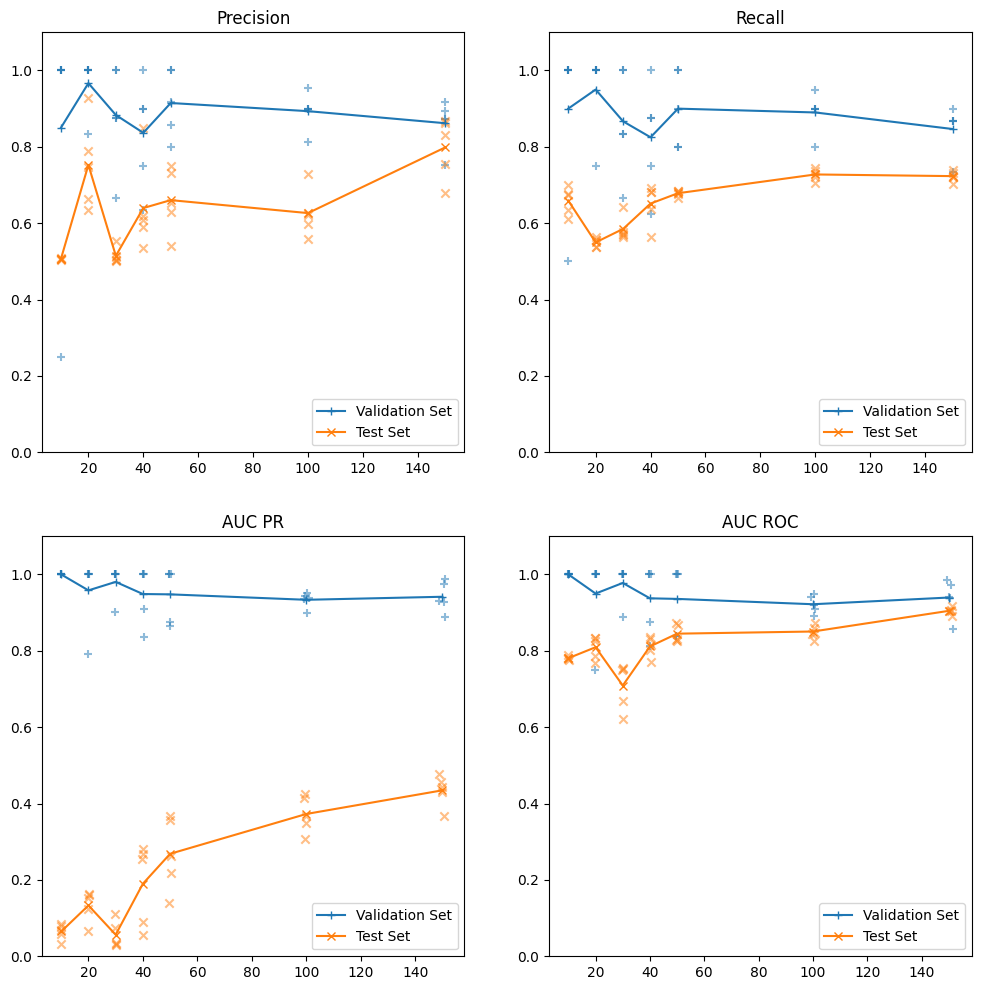

In [274]:
counts_samples = df.keys()

plt.figure(figsize=(12, 12))

plt.subplot(221)
f1_valid, f1_test = return_metrics_value_from_result_file(result_path, 'precision')
plot_from_metric_results(counts_samples, f1_valid, f1_test)
plt.title('Precision')

plt.subplot(222)
precision_valid, precision_test = return_metrics_value_from_result_file(result_path, 'recall')
plot_from_metric_results(counts_samples, precision_valid, precision_test)
plt.title('Recall')

plt.subplot(223)
auc_pr_valid, auc_pr_test = return_metrics_value_from_result_file(result_path, 'auc_pr')
plot_from_metric_results(counts_samples, auc_pr_valid, auc_pr_test, jitterX=0.02)
plt.title('AUC PR')

plt.subplot(224)
auc_roc_valid, auc_roc_test = return_metrics_value_from_result_file(result_path, 'auc_roc')
plot_from_metric_results(counts_samples, auc_roc_valid, auc_roc_test, jitterX=0.02)
plt.title('AUC ROC')

In [ ]:
auc_roc_valid, auc_roc_test = return_metrics_value_from_result_file(result_path, 'f1')
plot_from_metric_results(counts_samples, auc_roc_valid, auc_roc_test, jitterX=0.02)
plt.title('F1 score')

## Inference stage: write the trained model's classification results
Part not needed for the experiments but should be functional to display detection per file and save predictions in raven files

In [ ]:
threshold = 0.90  #@param

# Define a path to save the detections file
output_filepath = os.path.join(output_directory, dataset_folder, 'detections' + target_sound + str(threshold) + '.csv')

def classify_batch(batch):
  """Classify a batch of embeddings."""
  emb = batch[tf_examples.EMBEDDING]
  emb_shape = tf.shape(emb)
  flat_emb = tf.reshape(emb, [-1, emb_shape[-1]])
  logits = model(flat_emb)
  logits = tf.reshape(
      logits, [emb_shape[0], emb_shape[1], tf.shape(logits)[-1]])
  
  # compute softmax of the logits
  confidence = tf.nn.softmax(logits, axis=-1)
  confidence = tf.reduce_max(confidence, axis=-2)
  batch['confidence'] = confidence

  # Take the maximum logit over channels.
  logits = tf.reduce_max(logits, axis=-2)
  batch['logits'] = logits
  return batch


inference_ds = embeddings_ds.map(
    classify_batch, num_parallel_calls=tf.data.AUTOTUNE
)
all_embeddings = []
# all_logits = []
all_confidence = []

with open(output_filepath, 'w') as f:
  # Write column headers.
  # headers = ['filename', 'timestamp_s', 'label', 'logit', 'confidence']
  headers = ['filename', 'timestamp_s', 'label', 'confidence']

  f.write(', '.join(headers) + '\n')
  for ex in tqdm(inference_ds.as_numpy_iterator()):
    all_embeddings.append(ex['embedding'])
    # all_logits.append(ex['logits'])
    all_confidence.append(ex['confidence'])
    for t in range(ex['logits'].shape[0]):
      for i, label in enumerate(merged.labels):
        if ex['confidence'][t, i] > threshold:
          offset = ex['timestamp_s'] + t * hop_size_s

          # logit = '{:.2f}'.format(ex['logits'][t, i])
          confidence = '{:.4f}'.format(ex['confidence'][t, i])
          row = [ex['filename'].decode('utf-8'),
                 '{:.2f}'.format(offset),
                 label,
                #  logit,
                 confidence]
          f.write(', '.join(row) + '\n')

all_embeddings = np.concatenate(all_embeddings, axis=0)
# all_logits = np.concatenate(all_logits, axis=0)
print('Saved results to: ', output_filepath)

## Load inference results

In [ ]:
# Quick count and visualization of the detection per file
detections_df = pd.read_csv(output_filepath)

# Remove prediction of Noise
detections_df_call = detections_df[detections_df[' label'] != ' Unknown']
print("Number of occurence detected: ", len(detections_df_call))

# Assuming 'filename' is a column in your dataframe
filename_counts = detections_df_call['filename'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(filename_counts.index, filename_counts.values)
plt.xlabel('Filename')
plt.ylabel('Number of detections')
plt.title('Number of detections per file')
plt.xticks(rotation=90)  # rotate x-axis labels for better readability
plt.show()

### Convert detections to Raven Pro format

In [ ]:
# CSV to Raven format
def eval_to_Raven(prediction_file, wind_dur, keep_only_call=True):
    """ Convert a detections csv file into several files, one file per audio files in the Raven Pro format
        return None, save all files in a subdirectory "Raven file" where the prediction file is.
    Args:
     - prediction_file: path to the file containing the detections
     - wind_dur: size of the detection window to calculate the end of the annotations
     - keep_only_call: set to false to keep the annotation of noise class as well
     Output:
     - None
      """
    
    predicted_events = pd.read_csv(prediction_file, sep=',')
    if keep_only_call:
        predicted_events = predicted_events.loc[predicted_events[' label'] != ' Unknown']

    source_dir, filename = os.path.split(prediction_file)
    raven_dir = os.path.join(source_dir, 'Raven file/')
    if not os.path.exists(raven_dir):
        os.makedirs(raven_dir)

    list_predicted_files = predicted_events.groupby(['filename'])

    for _idx, predicted_file  in list_predicted_files:

        raven_file_df = pd.DataFrame({'Begin Time (s)': predicted_file[' timestamp_s'], 'End Time (s)': predicted_file[' timestamp_s']+wind_dur})
        raven_file_df.index.name = 'Selection'
        raven_file_df['View'] = 'Spectrogram 1'
        raven_file_df['Channel'] = 1
        raven_file_df['Low Freq (Hz)'] = 0
        raven_file_df['High Freq (Hz)'] = 16000
        raven_file_df['Type'] = predicted_file[' label']
        # raven_file_df['Logit'] = predicted_file[' logit']
        raven_file_df['Confidence Score'] = predicted_file[' confidence']*100 # Confidence score to percentage


        if raven_file_df.index[0] == 0: # Raven does not support index starting at 0
            raven_file_df.index += 1

        dest_filepath = raven_dir + os.path.basename(predicted_file['filename'].iloc[0])[:-4] +'.txt'
        try:
            raven_file_df.to_csv(dest_filepath, sep='\t')
            
        except Exception as e:
            print("Could not save the annotations in a csv file:", e)

    print('Raven annotation saved in files in folder:', raven_dir)

In [ ]:
eval_to_Raven(prediction_file=output_filepath, wind_dur=5, keep_only_call=True)